In [1]:
import rediscluster
import json

import torch
import torch.nn as nn
import tensorflow as tf
import numpy as np
# from .at import *
from at import *
from sklearn.manifold import spectral_embedding
from sklearn.preprocessing import normalize
import networkx as nx
import random

from sklearn.cluster import KMeans
from matplotlib.pylab import show, cm, axis
import logging
import time
import json
import sys
from collections import defaultdict
import pickle
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
# from mcl import run_mcl, get_clusters
import redis

color = {0:"red",1:"darkgrey", 2:"blue",3:"green",4:"y",5:"fuchsia",6:"lime",7:"orange",8:"pink",9:"cyan",10:"y",11:"black",12:"black",13:"black",14:"red", 15:"blue",16:"red", 17:"blue",18:"cyan",19:"darkgrey",20:"fuchsia",21:"lime",22:"orange",23:"pink",24:"green"}

In [2]:
class Attention_layer(tf.keras.layers.Layer):
    def __init__(self, input_size, hidden_size, batch_size, M, A):
        super().__init__()
        w_init = tf.random_normal_initializer()
        self.al = tf.Variable(initial_value=w_init(shape=(1, hidden_size), dtype='float32'), trainable=True)
        self.ar = tf.Variable(initial_value=w_init(shape=(1, hidden_size), dtype='float32'), trainable=True)
        self.W = tf.Variable(initial_value=w_init(shape=(hidden_size, input_size), dtype='float32'), trainable=True)
        self.relu = tf.keras.layers.LeakyReLU(alpha=0.2)
        
        self.M = M
        self.A = A
    
    def call(self, x):
        S0 = tf.matmul(tf.linalg.diag(tf.matmul(self.al, tf.matmul(self.W, x))[0]), self.M) 
        S1 = tf.matmul(self.M, tf.linalg.diag(tf.matmul(self.ar, tf.matmul(self.W, x))[0]))
        S = S0 + S1
        numerator = tf.exp(self.relu(S))
        denominator = tf.reshape(tf.reduce_sum(numerator * self.A, axis=1), [-1, 1])
        alpha = numerator / denominator
        Z = tf.tanh(tf.matmul(tf.matmul(self.W, x), alpha * self.A))
        return Z

        

class Encoder(tf.keras.layers.Layer):
    def __init__(self, input_size1, hidden_size1, input_size2, hidden_size2, batch_size, M, A):
        super().__init__()
        w_init = tf.random_normal_initializer()
        self.layer1 = Attention_layer(input_size1, hidden_size1, batch_size, M, A)
#         self.layer2 = Attention_layer(input_size2, hidden_size2, batch_size, M, A)
        
    def call(self, x):
        Z = self.layer1(x)
#         Z = self.layer2(Z)
        return Z

In [3]:


# number of nodes to use
numnodes = 800

# generate random positions as a dictionary where the key is the node id and the value
# is a tuple containing 2D coordinates
positions = {i:(random.random() * 2 - 1, random.random() * 2 - 1) for i in range(numnodes)}

# use networkx to generate the graph
network = nx.random_geometric_graph(numnodes, 0.3, pos=positions)

# then get the adjacency matrix (in sparse form)
matrix = nx.to_scipy_sparse_matrix(network)

emb_size = 64
# n = 200
X = spectral_embedding(matrix, n_components=emb_size).astype(np.float32).T
A = matrix.astype(np.float32).todense()

t = 2
tran_prob = normalize(A, norm="l1", axis=0)
M = sum([np.linalg.matrix_power(tran_prob, i) for i in range(1, t+1)]) / t
print(X.shape)

input_size1  = emb_size
hidden_size1 = 32
input_size2 = hidden_size1
hidden_size2 = 16
batch_size = numnodes
encoder = Encoder(input_size1, hidden_size1, input_size2, hidden_size2, batch_size, M, A)

(64, 800)


In [4]:
loss_object = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam()

# @tf.function
def train_step(X, labels):
    with tf.GradientTape() as tape:
        y = encoder(X)
        predictions = tf.sigmoid(tf.matmul(tf.transpose(y), y))
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, encoder.trainable_variables)
    optimizer.apply_gradients(zip(gradients, encoder.trainable_variables))

In [5]:
for i in range(800):
    train_step(X, A*3)
    
    if i % 100 == 0:
        y = encoder(X)
        predictions = tf.sigmoid(tf.matmul(tf.transpose(y), y))
        loss = loss_object(A*3, predictions)
        print(i // 100, loss, y[:5, 0].numpy().tolist())

(predictions, predictions[0,232], A[0,232])

0 tf.Tensor(0.62679815, shape=(), dtype=float32) [0.0002219514863099903, -2.7488322302815504e-05, -0.00021336071949917823, 0.0007368951337412, -0.0005879561067558825]
1 tf.Tensor(0.62679595, shape=(), dtype=float32) [0.00016385040362365544, 5.37361775059253e-05, -0.00016680984117556363, 0.0010927246185019612, -0.0008607659838162363]
2 tf.Tensor(0.6267878, shape=(), dtype=float32) [4.2546260374365374e-05, 0.00027427758323028684, 8.10005294624716e-05, 0.0019410649547353387, -0.0016904196236282587]
3 tf.Tensor(0.6267652, shape=(), dtype=float32) [-6.323325942503288e-05, 0.0005112600047141314, 0.0005486697191372514, 0.0032509479206055403, -0.00327759119682014]
4 tf.Tensor(0.62671506, shape=(), dtype=float32) [-9.359518458040839e-07, 0.0004663069557864219, 0.0010476725874468684, 0.004749729763716459, -0.005380998365581036]
5 tf.Tensor(0.62662596, shape=(), dtype=float32) [0.00030082426383160055, 7.49848459236091e-06, 0.0014130830531939864, 0.00617663050070405, -0.007565236184746027]
6 tf.Te

(<tf.Tensor: id=126132, shape=(800, 800), dtype=float32, numpy=
 array([[0.50023496, 0.49991748, 0.50040513, ..., 0.50030667, 0.50029415,
         0.49994683],
        [0.49991748, 0.50041616, 0.49989465, ..., 0.4998903 , 0.49964422,
         0.5000501 ],
        [0.50040513, 0.49989465, 0.50202435, ..., 0.5011144 , 0.50014466,
         0.4994883 ],
        ...,
        [0.50030667, 0.4998903 , 0.5011144 , ..., 0.5007225 , 0.50030845,
         0.49972886],
        [0.50029415, 0.49964422, 0.50014466, ..., 0.50030845, 0.5042065 ,
         0.49947748],
        [0.49994683, 0.5000501 , 0.4994883 , ..., 0.49972886, 0.49947748,
         0.5017052 ]], dtype=float32)>,
 <tf.Tensor: id=143883, shape=(), dtype=float32, numpy=0.4999557>,
 0.0)

In [6]:
nclu = 6
kmeans = KMeans(n_clusters=nclu)
cl = kmeans.fit_predict(y.numpy().T)
# cls2 = dict(zip(ips, cl))


mu = tf.Variable(initial_value=kmeans.cluster_centers_.T, trainable=True)

In [7]:
z = tf.transpose(y)
sqsumz = tf.tile(tf.reshape(tf.reduce_sum(z**2, axis=1), (-1,1)), [1,nclu])
sqsummu = tf.tile(tf.transpose(tf.reshape(tf.reduce_sum(mu ** 2, axis=0),(-1, 1))), [batch_size,1])
zmu = tf.matmul(z, mu)
sqdist = sqsumz + sqsummu - 2 * zmu

q = (1 / (1 + sqdist )) / tf.tile(tf.reshape(tf.reduce_sum(1 / (1 + sqdist ), axis=1), [-1, 1]), [1, nclu])

pn = q**2 / tf.tile(tf.reshape(tf.reduce_sum(q, axis = 0), [1,-1]), [batch_size,1])
pd = tf.tile(tf.reshape(tf.reduce_sum(q**2 / tf.tile(tf.reshape(tf.reduce_sum(q, axis = 0), [1,-1]), [batch_size,1]), axis=1), [-1, 1]), [1, nclu])
p = pn / pd

In [8]:
loss_object_r = tf.keras.losses.KLDivergence()
optimizer_r = tf.keras.optimizers.Adam()

In [9]:
for i in range(400):
    with tf.GradientTape() as tape:
        z = tf.transpose(encoder(X))
        
        sqsumz = tf.tile(tf.reshape(tf.reduce_sum(z**2, axis=1), (-1,1)), [1,nclu])
        sqsummu = tf.tile(tf.transpose(tf.reshape(tf.reduce_sum(mu ** 2, axis=0),(-1, 1))), [batch_size,1])
        zmu = tf.matmul(z, mu)
        sqdist = sqsumz + sqsummu - 2 * zmu
        q = (1 / (1 + sqdist )) / tf.tile(tf.reshape(tf.reduce_sum(1 / (1 + sqdist ), axis=1), [-1, 1]), [1, nclu])
        
        if i % 5 == 0:
            pn = q**2 / tf.tile(tf.reshape(tf.reduce_sum(q, axis = 0), [1,-1]), [batch_size,1])
            pd = tf.tile(tf.reshape(tf.reduce_sum(q**2 / tf.tile(tf.reshape(tf.reduce_sum(q, axis = 0), [1,-1]), [batch_size,1]), axis=1), [-1, 1]), [1, nclu])
            p = pn / pd
        
        
        loss = loss_object_r(p, q)
    gradients = tape.gradient(loss, encoder.trainable_variables + [mu])
    optimizer_r.apply_gradients(zip(gradients, encoder.trainable_variables + [mu]))


    if i % 40 == 0:
        print(loss)
    

tf.Tensor(3.005811e-05, shape=(), dtype=float32)
tf.Tensor(0.000118816046, shape=(), dtype=float32)
tf.Tensor(0.00033996263, shape=(), dtype=float32)
tf.Tensor(0.0006478979, shape=(), dtype=float32)
tf.Tensor(0.00096256065, shape=(), dtype=float32)
tf.Tensor(0.0012560409, shape=(), dtype=float32)
tf.Tensor(0.0015399099, shape=(), dtype=float32)
tf.Tensor(0.0018424678, shape=(), dtype=float32)
tf.Tensor(0.0021824478, shape=(), dtype=float32)
tf.Tensor(0.0025461542, shape=(), dtype=float32)


In [10]:

kmeans = KMeans(n_clusters=nclu)
cl = kmeans.fit_predict(z.numpy())
# cls2 = dict(zip(ips, cl))
clus = [[] for _ in range(nclu)]
for i in range(len(cl)):
    clus[cl[i]].append(i)
# mu = tf.Variable(initial_value=kmeans.cluster_centers_.T, trainable=True)

/home/root123/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


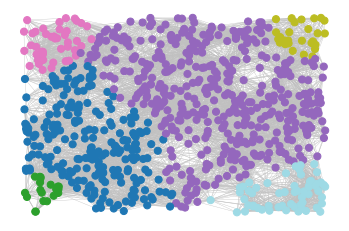

In [11]:

def draw_graph(matrix, clusters, **kwargs):
    """
    Visualize the clustering
    
    :param matrix: The unprocessed adjacency matrix
    :param clusters: list of tuples containing clusters as returned
                     by 'get_clusters'
    :param kwargs: Additional keyword arguments to be passed to
                   networkx.draw_networkx
    """
    # make a networkx graph from the adjacency matrix
    graph = nx.Graph(matrix)
    
    # map node to cluster id for colors
    cluster_map = {node: i for i, cluster in enumerate(clusters) for node in cluster}
    colors = [cluster_map[i] for i in range(len(graph.nodes()))]
    
    # if colormap not specified in kwargs, use a default
    if not kwargs.get("cmap", False):
        kwargs["cmap"] = cm.tab20
    
    # draw
    nx.draw_networkx(graph, node_color=colors,width = 0.351, **kwargs)
    axis("off")
    show(block=False)
draw_graph(matrix, clus, pos=positions, node_size=50, with_labels=False, edge_color="silver")